<font size="5">**Connecting to the database**</font>
<br /><br />
<font size="3">First, we import the necessary libraries.</font>

In [1]:
import mysql.connector as mysql
import database as db
import csv, sys
import image_generator
#!export CUDA_VISIBLE_DEVICES=""
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#!unset CUDA_VISIBLE_DEVICES

<font size="3">Now, we establish the connection.</font>

In [2]:
myDB = db.connect_db("inference")
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]

<font size="5">**Extracting the features**</font>

<font size="3">We start the image generator class and choose the range of images.</font>

In [3]:
image_generator.main()
imgGen = image_generator.ImageGenerator('images/val/images', 'images/val/val.txt', 'images/val/synset_words.txt')
label_list = imgGen.get_label_list() 

images/val/images\ILSVRC2012_val_00013113.JPEG French horn, horn
images/val/images\ILSVRC2012_val_00009670.JPEG common newt, Triturus vulgaris
images/val/images\ILSVRC2012_val_00028291.JPEG proboscis monkey, Nasalis larvatus
images/val/images\ILSVRC2012_val_00031659.JPEG abacus
images/val/images\ILSVRC2012_val_00041114.JPEG ostrich, Struthio camelus
images/val/images\ILSVRC2012_val_00037347.JPEG otterhound, otter hound
images/val/images\ILSVRC2012_val_00045643.JPEG jacamar
images/val/images\ILSVRC2012_val_00033646.JPEG oscilloscope, scope, cathode-ray oscilloscope, CRO
images/val/images\ILSVRC2012_val_00003760.JPEG cowboy hat, ten-gallon hat
images/val/images\ILSVRC2012_val_00035134.JPEG wild boar, boar, Sus scrofa


In [4]:
img_nums = []
for i in range(1, 20001):                 # the range of images can be selected here
    img_nums.append(i)

img_paths = []
filenames = []
for i in range(len(img_nums)):
    img_path, img_label = imgGen.get_image_data(img_nums[i])
    img_paths.append(img_path)                                             # we obtain the image paths and filenames
for i in range(len(img_nums)):
    img_name = imgGen.get_image_filename(img_nums[i])
    filenames.append(img_name)

<font size="3">Extracting the <font color="green">seven</font> selected features from the images.</font>

20000


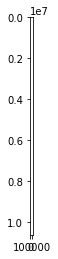

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import math
from scipy import ndimage


features_list = []
for i in range(len(img_paths)):
    filename = img_paths[i]
    img = cv2.imread(filename, 3)
    plt.imshow(img)

    aspect_ratio = img.shape[1] / img.shape[0]                     # aspect ratio                     


    B = np.mean(img[0])
    G = np.mean(img[1])
    R = np.mean(img[2])
    average_perceived_brightness = (math.sqrt(0.241*(R**2) + 0.691*(G**2) + 0.068*(B**2)))  # average percevied brightness


    edges = cv2.Canny(img, 100, 200)
    plt.imshow(edges, cmap = "gray")
    threshold = 100
    labeled, nr_objects = ndimage.label(edges > threshold) 
    unique, lengths = np.unique(labeled, return_counts=True)
    y, x, g = plt.hist(lengths[1:], bins = 7)
    y_min = np.where(y == y.min())[0][0]
    x_min = np.mean((x[y_min:y_min + 2]))
    y_max = np.where(y == y.max())[0][0]
    x_max = np.mean((x[y_max:y_max + 2]))
    edge_length1 = ((x_max * y.max()) + (x_min * y.min())) / (y.max() + y.min())           # edge length
    
    #edges = cv2.Canny(img, 100, 200)
    #plt.imshow(edges, cmap = "gray")
    #threshold = 100
    #labeled, nr_objects = ndimage.label(edges > threshold) 
    #unique, lengths = np.unique(labeled, return_counts=True)
    #y, x, g = plt.hist(lengths[1:], bins = 7)
    #y_max = np.where(y == y.max())[0][0]
    #x_max = np.mean((x[y_max:y_max + 2]))
    #edge_length1 = ((x_max * y.max())) / (y.max())

    
   
    hsv = cv2.cvtColor( img, cv2.COLOR_BGR2HSV )
    hue, sat, val = cv2.split(hsv)
    hue = hue.flatten()
    y, x, bars = plt.hist(hue, bins = 7)
    y_min = np.where(y == y.min())[0][0]
    x_min = np.mean((x[y_min:y_min + 2]))
    y_max = np.where(y == y.max())[0][0]
    x_max = np.mean((x[y_max:y_max + 2]))
    hue1 = ((x_max * y.max()) + (x_min * y.min())) / (y.max() + y.min())             # hue

    #hsv = cv2.cvtColor( img, cv2.COLOR_BGR2HSV )
    #hue, sat, val = cv2.split(hsv)
    #hue = hue.flatten()
    #y, x, bars = plt.hist(hue, bins = 7)
    #y_max = np.where(y == y.max())[0][0]
    #x_max = np.mean((x[y_max:y_max + 2]))
    #hue1 = ((x_max * y.max())) / (y.max())


    area_by_perim = img.shape[0] * img.shape[1] / ((img.shape[0] + img.shape[1]) * 2)             # area by perimeter


    imgGrey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    contrast = imgGrey.std()                                          # contrast


    orb = cv2.ORB_create(nfeatures = 10000) 
    keypoints, descriptors = orb.detectAndCompute(img, None)
    kp_surf = len(keypoints)                                            # number of keypoints


    arr = np.array([kp_surf, average_perceived_brightness, contrast, area_by_perim, aspect_ratio,
                    edge_length1, hue1])                                    # inserting all seven features into an array

    features_list.append(arr)                               # appending them to a list

print(len(features_list))

<font size="3">Scaling the data into the range 0-1.</font>

In [6]:
import sklearn.preprocessing
features_list = np.asarray(features_list)
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0, 1))        # scaling of features 0-1
features_list = min_max_scaler.fit_transform(features_list)

<font size="5">**Determining the best <font color="green">top-1</font> and <font color="green">top-5</font> model for each image**</font>

<font size="3">Connecting to the database to determine the best top-1 and top-5 models for each image.</font>

In [7]:
best_top_1 = []
best_top_5 = []
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]
for i in range(len(img_nums)):

    best_top_1.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 1))

    best_top_5.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 5))

In [8]:
top_1_best_models = []              # appending the values representing the best top-1 model
for i in range(len(best_top_1)):
    if best_top_1[i] == 'mobilenet_v1':
        top_1_best_models.append([1, 0, 0])
    elif best_top_1[i] == 'inception_v4':
        top_1_best_models.append([0, 1, 0])
    elif best_top_1[i] == 'resnet_v1_152':
        top_1_best_models.append([0, 0, 1])
    elif best_top_1[i] == 'failed':
        top_1_best_models.append([0, 0, 0])

<font size="5">**Writing the data to a csv file**</font>
<br /><br />
<font size="3">Creating the best <font color="green">top-1</font> model csv.</font>

In [9]:
import csv, sys
filename = 'all_new_features_hier_norm_top_1.csv'
with open('all_new_features_hier_norm_top_1.csv', mode='w', newline='') as featuresFile:
    features_writer = csv.writer(featuresFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf',
                              'average_perceived_brightness', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 
                             'hue1'])
    for i in range(len(features_list)):
        row = ([filenames[i], top_1_best_models[i][0], top_1_best_models[i][1], top_1_best_models[i][2], features_list[i][0], features_list[i][1], features_list[i][2],
               features_list[i][3], features_list[i][4], features_list[i][5], features_list[i][6]])
        features_writer.writerow(row)

<font size="3">Completing the same operation for <font color="green">top-5</font>.</font>

In [10]:
top_5_best_models = []                                        # this part is for the best top 5 model
for i in range(len(best_top_5)):
    if best_top_5[i] == 'mobilenet_v1':
        top_5_best_models.append([1, 0, 0])
    elif best_top_5[i] == 'inception_v4':
        top_5_best_models.append([0, 1, 0])
    elif best_top_5[i] == 'resnet_v1_152':
        top_5_best_models.append([0, 0, 1])
    elif best_top_5[i] == 'failed':
        top_5_best_models.append([0, 0, 0])

In [11]:
import csv, sys
filename = 'all_new_features_hier_norm_top_5.csv'
with open('all_new_features_hier_norm_top_5.csv', mode='w', newline='') as featuresFile:
    features_writer = csv.writer(featuresFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf',
                              'average_perceived_brightness', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 
                             'hue1'])
    for i in range(len(features_list)):
        row = ([filenames[i], top_5_best_models[i][0], top_5_best_models[i][1], top_5_best_models[i][2], features_list[i][0], features_list[i][1], features_list[i][2],
               features_list[i][3], features_list[i][4], features_list[i][5], features_list[i][6]])
        features_writer.writerow(row)